# Investigate and remove spatial outliers

Let's take a look at all structures that contain residues (CA atoms) with a distance to the `kissim` subpocket centers below/above a certain minimum/maximum cutoff. 

This allows us to identify outlier structures that we want to exclude from our dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from opencadd.structure.pocket import PocketKlifs, PocketViewer
from opencadd.databases.klifs import setup_remote

from kissim.io import PocketDataFrame
from kissim.encoding import FingerprintGenerator, FingerprintNormalized
from kissim.definitions import DISTANCE_CUTOFFS

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])
RESULTS = HERE / "../../results/"

In [5]:
REMOTE = setup_remote()

## Set distance minimum/maximum cutoffs

These cutoffs define spatial outliers.

In [6]:
DISTANCE_CUTOFFS = {
    "hinge_region": (1, 34),
    "dfg_region": (1, 34),
    "front_pocket": (1, 34),
    "center": (1, 34),
}
print(f"Use the following distance minimum/maximum cutoffs to identify outlier structures: {DISTANCE_CUTOFFS}")

Use the following distance minimum/maximum cutoffs to identify outlier structures: {'hinge_region': (1, 34), 'dfg_region': (1, 34), 'front_pocket': (1, 34), 'center': (1, 34)}


## Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [7]:
fingerprint_generator = FingerprintGenerator.from_json(
    RESULTS / "fingerprints.json", normalize=True
)
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4918


## Get distance features

Lets load distances (from each residue to each subpocket center) for all fingerprints.

In [8]:
distances = fingerprint_generator.distances_exploded()
distances

hinge_region  dfg_region  front_pocket  \
structure_klifs_id residue_ix                                           
3835               1              12.798095   19.079805     14.099948   
                   2              11.640075   16.481350     11.632327   
                   3               9.240445   15.125156      8.279718   
                   4              10.344351   13.665039      7.234169   
                   5              12.414604   12.788149      9.114764   
...                                     ...         ...           ...   
7219               81              8.892165    7.109349      6.723064   
                   82             11.366709    6.088001     10.422721   
                   83             13.247789    5.919116     11.564625   
                   84             16.129894    9.708284     13.088131   
                   85             16.746517   10.580341     14.536907   

                                  center  
structure_klifs_id residue_ix             
3835               1           17.262426  
                   2           15.175342  
                   3           12.447825  
                   4           11.853809  
                   5           12.903294  
...                                  ...  
7219               81           3.793342  
                   82           6.788561  
                   83           9.319808  
                   84          11.473628  
                   85          11.731262  

[418030 rows x 4 columns]

In [9]:
distances.describe()

,hinge_region,dfg_region,front_pocket,center
count,410834.000000,406621.000000,410851.000000,411460.000000
mean,12.874321,13.579542,13.035534,12.006524
std,4.570431,4.867160,4.282973,3.489024
min,2.689810,0.873535,1.355564,0.890513
25%,9.574859,9.924037,9.857139,9.900404
50%,12.555706,13.298841,12.458632,12.020822
75%,15.969992,16.742859,16.170794,13.688982
max,48.509457,50.127373,40.766365,47.974854


## Get structures with extreme distances

Let's plot distance histograms (over all residue positions) per subpocket center and retain only extreme distances.

In [10]:
def extreme_distances(distances, feature_type, distance_cutoffs):

    cutoff_min = distance_cutoffs[feature_type][0]
    cutoff_max = distance_cutoffs[feature_type][1]

    features = distances[feature_type]
    range_full = round(features.max() - features.min(), 2)
    features_min = features[features < cutoff_min]
    features_max = features[features > cutoff_max]
    range_min_max = cutoff_max - cutoff_min
    n_structures_below_min = len(features_min.reset_index()["structure_klifs_id"].unique())
    n_structures_above_max = len(features_max.reset_index()["structure_klifs_id"].unique())
    n_residues_below_min = len(features_min.reset_index()["residue_ix"].unique())
    n_residues_above_max = len(features_max.reset_index()["residue_ix"].unique())
    range_below_min = round(features_min.max() - features_min.min(), 2)
    range_above_max = round(features_max.max() - features_max.min(), 2)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
    fig.suptitle(f"Extreme distances seen in subpocket {feature_type}", fontsize="x-large")
    axes[0].axvspan(cutoff_min, cutoff_max, color="cyan", alpha=0.1)
    features.plot(
        kind="hist",
        bins=100,
        ax=axes[0],
        title=f"All structures (full range {range_full} A, cutoff range {range_min_max} A / cyan)",
    )
    features_min.plot(
        kind="hist",
        ax=axes[1],
        title=f"Below {cutoff_min} A: #{n_structures_below_min} structures | #{n_residues_below_min} residue positions (range {range_below_min} A)",
    )
    features_max.plot(
        kind="hist",
        ax=axes[2],
        title=f"Above {cutoff_max} A: #{n_structures_above_max} structures | #{n_residues_above_max} residue positions (range {range_above_max} A)",
    )

    return features_min, features_max

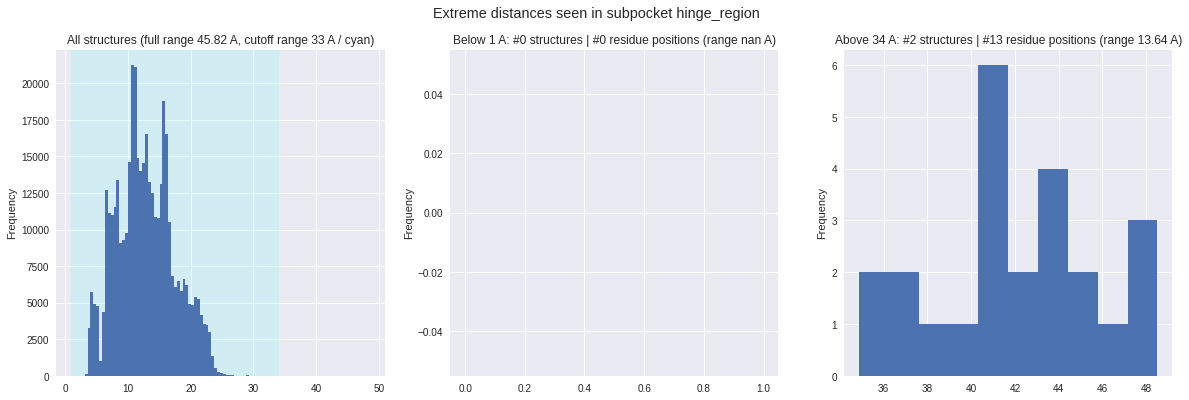

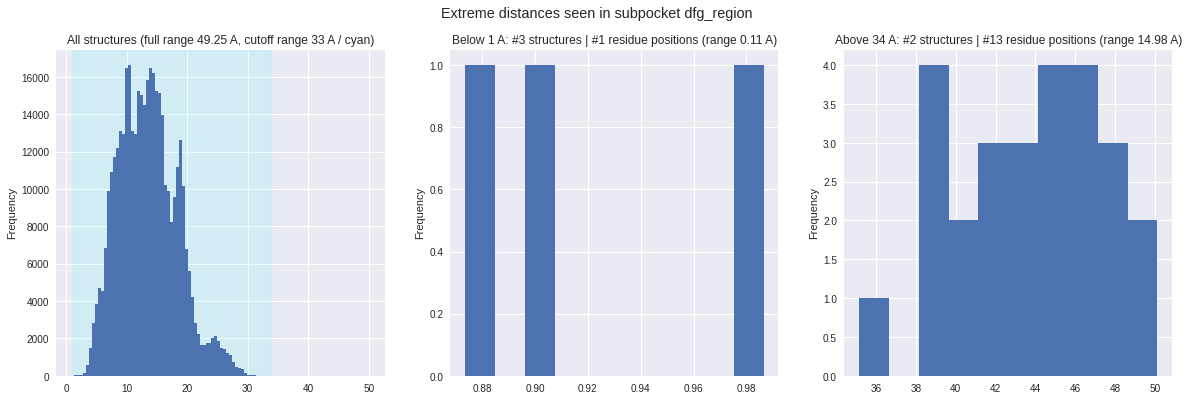

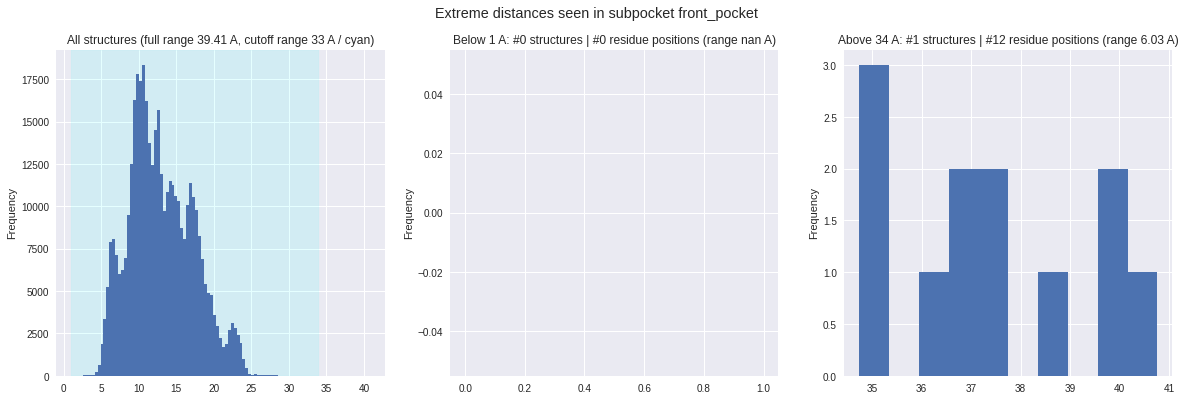

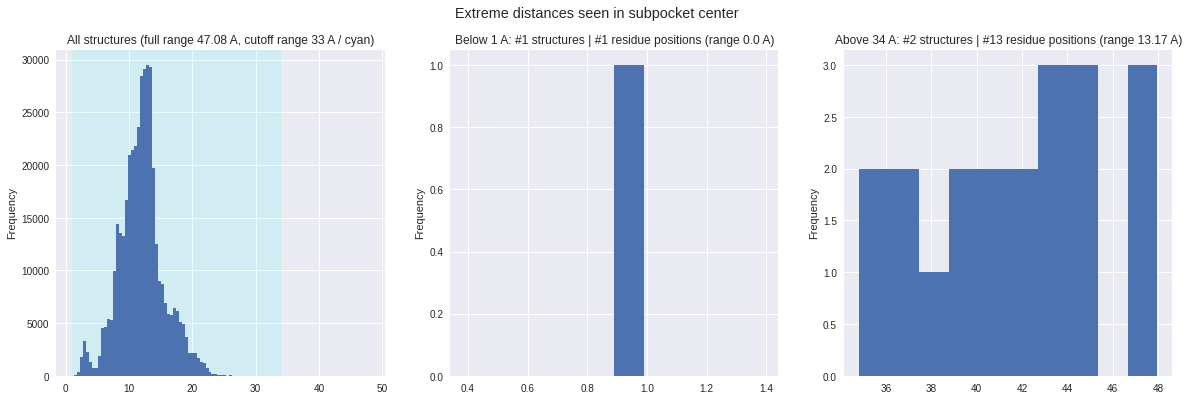

In [11]:
extreme_features = {}
for feature_type, _ in distances.items():
    features_min, features_max = extreme_distances(distances, feature_type, DISTANCE_CUTOFFS)
    extreme_features[feature_type] = (features_min, features_max)

__Note__: We will not define a minimum cutoff because it is possible that a subpocket center sits very closely to a residue CA atom and thus, in this case we would not speak of an outlier. In the following we will only focus on the long distances outliers.

### Pocket center

In [12]:
extreme_features["center"][1]

structure_klifs_id  residue_ix
59                  4             34.805298
                    5             36.548412
                    6             36.928802
                    7             40.036869
                    8             38.932343
                    9             37.584431
                    10            35.553322
7083                1             45.098946
                    2             43.218914
                    3             40.437546
                    4             43.078079
                    5             43.831482
                    6             47.207050
                    7             47.974854
                    8             47.151520
                    9             44.468346
                    10            44.825668
                    11            41.863220
                    12            41.417728
                    13            41.197952
Name: center, dtype: float64

In [13]:
extreme_features["center"][1].reset_index().groupby("residue_ix").size()

residue_ix
1     1
2     1
3     1
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    1
12    1
13    1
dtype: int64

extreme_features["center"][1].index.get_level_values("structure_klifs_id").unique().to_list()

### Front pocket

In [14]:
extreme_features["front_pocket"][1].reset_index().groupby("residue_ix").size()

residue_ix
1     1
2     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
dtype: int64

In [15]:
extreme_features["front_pocket"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[7083]

Structure already detected in "Pocket center".

### Hinge region

In [16]:
extreme_features["hinge_region"][1].reset_index().groupby("residue_ix").size()

residue_ix
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    1
13    1
dtype: int64

In [17]:
extreme_features["hinge_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[59, 7083]

Structures already detected in "Pocket center".

### DFG region

In [18]:
extreme_features["dfg_region"][1].reset_index().groupby("residue_ix").size()

residue_ix
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
dtype: int64

In [19]:
extreme_features["dfg_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[59, 7083]

## Look at structures with extremely long distances

In [20]:
extreme_structures_max = []
for subpocket_name, features in extreme_features.items():
    extreme_structures_max.extend(features[1].index.get_level_values("structure_klifs_id").unique())
extreme_structures_max = set(extreme_structures_max)

print(f"Structures with extremly long distances: {extreme_structures_max}")

Structures with extremly long distances: {59, 7083}


Look at these extreme structures in KLIFS/PDB:

- 4QD6 - chain A (model B) | IL2 inducible T-cell kinase
  - Kinase group: TK
  - https://klifs.net/details.php?structure_id=59
  - https://www.rcsb.org/structure/4qd6
  - https://www.sciencedirect.com/science/article/abs/pii/S0960894X14010658?via%3Dihub
    - No comment on flipped-out g-loop.
- 5J0A - chain A | PDZ binding kinase
  - Kinase group: Other
  - https://klifs.net/details.php?structure_id=7083
  - https://www.rcsb.org/structure/5j0a
  - https://www.sciencedirect.com/science/article/abs/pii/S0006291X16309184?via%3Dihub
    - "PBK may assemble into an inactive dimer in alkaline conditions."
    - "PBK exists in a conformational transition between dimers and monomers at different pH conditions."

In [21]:
viewer = PocketViewer()
for structure_klifs_id in extreme_structures_max:
    pocket = PocketKlifs.from_structure_klifs_id(structure_klifs_id)
    viewer.add_pocket(pocket)
viewer.viewer.display(gui=True)

ThemeManager()

NGLWidget(gui_style='ngl')

In [22]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

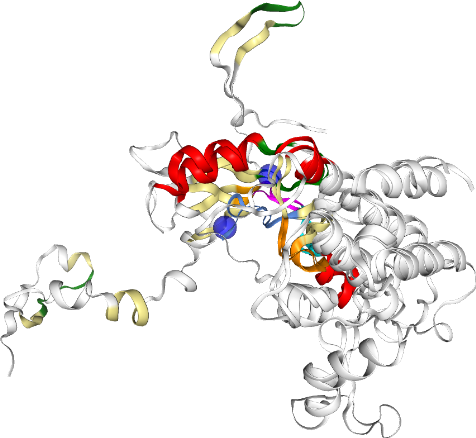

In [23]:
viewer.viewer._display_image()

## Drop fingerprints with extreme distances

Drop fingerprints for structures with extreme distances and save these cleaned fingerprints to disc.

In [24]:
print(f"Number of extreme structures: {len(extreme_structures_max)}")
fingerprint_generator_clean = fingerprint_generator
print(f"Number of structures: {len(fingerprint_generator_clean.data.keys())}")
for extreme_structure in extreme_structures_max:
    del fingerprint_generator_clean.data[extreme_structure]
print(f"Number of clean structures: {len(fingerprint_generator_clean.data.keys())}")

Number of extreme structures: 2
Number of structures: 4918
Number of clean structures: 4916


In [25]:
fingerprint_generator_clean.to_json(RESULTS / "fingerprints_clean.json")